# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import glob
from PIL import Image
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers,Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings("ignore")

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
#Import the dataset and read the image into a seperate variable

images=r'/home/datasets/flickr/Images'
# Please provide appropriate path before executing for submission

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [3]:
#Visualise both the images & text present in the dataset
Image.open(all_imgs[1])
all_imgs[1]

'/home/datasets/flickr/Images/2049051050_20359a434a.jpg'

In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    #your code here
    text = open(filename).read()
    return text
text_file = r'/home/datasets/flickr/captions.txt'
# Please provide appropriate path before executing for submission

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
def get_all_img_id_vector_captions(doc,index,vec):
    img_ids = []
    img_vecs = []
    doc = doc.splitlines()[1:] # starts with 1 to discard image,caption line
    for d in doc:
        img_ids.append(d.split(',')[index])
        img_vecs.append(images+'/'+d.split(',')[index])
    if vec==0:
        return img_ids
    else:
        return img_vecs    

all_img_id= get_all_img_id_vector_captions(doc,0,0)
all_img_vector= get_all_img_id_vector_captions(doc,0,1)
annotations= get_all_img_id_vector_captions(doc,1,0)

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/home/datasets/flickr/Images/1000268201_693b08...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/home/datasets/flickr/Images/1000268201_693b08...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/home/datasets/flickr/Images/1000268201_693b08...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/home/datasets/flickr/Images/1000268201_693b08...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/home/datasets/flickr/Images/1000268201_693b08...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/home/datasets/flickr/Images/997722733_0cb5439...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/home/datasets/flickr/Images/997722733_0cb5439...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/home/datasets/flickr/Images/997722733_0cb5439...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/home/datasets/flickr/Images/997722733_0cb5439...,A rock climber in a red shirt .


In [6]:
#Create a list which contains all the captions
annotations=get_all_img_id_vector_captions(doc,1,0)

#add the <start> & <end> token to all those captions as well
for index in range(0,len(annotations)):
    annotations[index] = str('<start>'+' '+annotations[index]+' '+'<end>')

#Create a list which contains all the path to the images
all_img_path=get_all_img_id_vector_captions(doc,0,1)

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [7]:
#Create the vocabulary & the counter for the captions
def get_all_words(df,column):
    res = []
    for cap in df[column]:
        res+=cap.split(" ")
    return res

vocabulary= get_all_words(df,'Captions')

val_count=Counter(vocabulary)
val_count

Counter({'A': 21480,
         'child': 1449,
         'in': 18170,
         'a': 38716,
         'pink': 701,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 1870,
         'entry': 1,
         'way': 48,
         '.': 34205,
         'girl': 3174,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1607,
         'playhouse': 6,
         'the': 14587,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3491,
         'dog': 7804,
         'and': 8057,
         'spotted': 36,
         'are': 3364,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7303,
         'each': 399,
         'other': 666,
         'on': 10354,
         'road': 380,
         'white': 3646,
         'brown': 2383,
         'spots': 28,
         'staring'

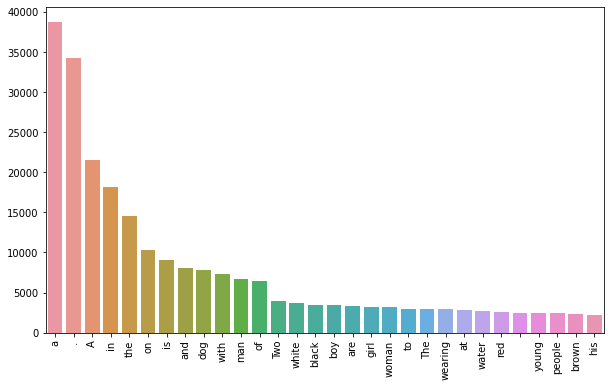

In [8]:
#Visualise the top 30 occuring words in the captions

#write your code here
top_30_val_count = sorted(val_count.items(), key=lambda x: x[1], reverse=True)[:30]

def get_top_30(list):
    top_30_keys = []
    top_30_values = []
    for val in list:
        top_30_keys.append(val[0])
        top_30_values.append(val[1])
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_30_keys,y=top_30_values)
    plt.xticks(rotation=90)
    plt.show()
get_top_30(top_30_val_count)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [9]:
# create the tokenizer

#your code here
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~',oov_token="<UNK>")
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
train_seqs[:5]

[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4],
 [3, 2, 20, 313, 64, 2, 197, 120, 4],
 [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4],
 [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4],
 [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]

In [10]:
# Create word-to-index and index-to-word mappings.

#your code here
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

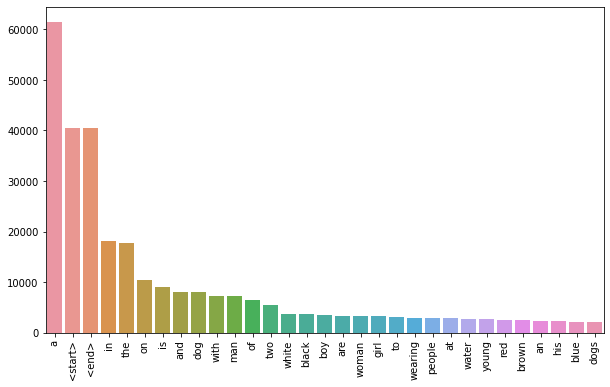

In [11]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
top_30_val_count = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:31]
get_top_30(top_30_val_count)

In [12]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

def max_of_seqs(seqs):
    max_len = 0
    for seq in seqs:
        if len(seq)>max_len:
            max_len = len(seq)
    return max_len
max_len = max_of_seqs(train_seqs)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_of_seqs(train_seqs))
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [13]:
#write your code here to create the dataset consisting of image paths
all_img_vector = get_all_img_id_vector_captions(doc,0,1)

In [14]:
#write your code here for creating the function. This function should return images & their path
def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img, (299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img,image_path

In [15]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
encode_train_set = list(set(all_img_vector))
img_dataset = tf.data.Dataset.from_tensor_slices(encode_train_set)
img_dataset = img_dataset.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
img_dataset

2024-01-14 08:14:02.486852: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-14 08:14:02.486917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [16]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input#write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output#write code here to get the output of the image_model

image_features_extract_model = keras.Model(new_input,hidden_layer)#build the final model using both input & output layer

In [17]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [18]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
feature_dict= {}
for img,path in tqdm(img_dataset):    
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0],-1,batch_features.shape[3]))
    for batch_feature,path in zip(batch_features,path):
        path_of_feature = path.numpy().decode("utf-8")
        feature_dict[path_of_feature] = batch_feature.numpy()

100%|██████████| 253/253 [00:40<00:00,  6.19it/s]


In [19]:
features_shape = batch_feature.shape[1]
attention_features_shape = batch_feature.shape[0]

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [20]:
#write your code here
image_train, image_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,train_size=0.8,random_state=33)

In [21]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [22]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_path,caption):
  img_tensor = feature_dict[img_path.decode('utf-8')]
  return img_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [23]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img_paths,img_captions):
    
    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((img_paths,img_captions))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)    
    return dataset

In [24]:
train_dataset=gen_dataset(image_train,cap_train)
test_dataset=gen_dataset(image_test,cap_test)

In [25]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [26]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train)//32 #len(total train images) // BATCH_SIZE
test_num_steps = len(image_test)//32 #len(total test images) // BATCH_SIZE

### Encoder

In [27]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        features = self.dense(features)
        features = tf.nn.relu(features)
        return features

In [28]:
encoder=Encoder(embedding_dim)

### Attention model

In [29]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)#build your Dense layer
        self.W2 = layers.Dense(units)#build your Dense layer
        self.V = layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = keras.activations.tanh(self.W1(features)+self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  keras.activations.softmax(self.V(score),axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights*features#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1)# reduce the shape to (batch_size, embedding_dim)
        return context_vector, attention_weights

### Decoder

In [30]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = layers.Embedding(vocab_size,embed_dim,mask_zero=False)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)#build your Dense layer
        self.d2 = layers.Dense(vocab_size)#build your Dense layer
        self.dropout = Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        embed = self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed,mask=mask)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [31]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [32]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [33]:
optimizer = keras.optimizers.Adam()#define the optimizer
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')#define your loss object

In [34]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [35]:
checkpoint_path = r"CheckPointFile"
# Please provide appropriate path before executing for submission
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [36]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [37]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in tqdm(range(1, target.shape[1])):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [38]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in tqdm(range(1, target.shape[1])):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [39]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [40]:
loss_plot = []
test_loss_plot = []
EPOCHS = 17

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

100%|██████████| 34/34 [00:07<00:00,  4.59it/s]

100%|██████████| 34/34 [00:07<00:00,  4.54it/s]

100%|██████████| 34/34 [00:07<00:00,  4.33it/s]

100%|██████████| 34/34 [00:07<00:00,  4.48it/s]

100%|██████████| 34/34 [00:07<00:00,  4.29it/s]


For epoch: 1, the train loss is 1.283, & test loss is 1.072
Time taken for 1 epoch 240.0116002559662 sec

Test loss has been reduced from 100.000 to 1.072


  6%|▌         | 1/17 [04:00<1:04:06, 240.42s/it]

For epoch: 2, the train loss is 1.002, & test loss is 0.951
Time taken for 1 epoch 134.0905168056488 sec

Test loss has been reduced from 1.072 to 0.951


 12%|█▏        | 2/17 [06:14<44:32, 178.13s/it]  

For epoch: 3, the train loss is 0.912, & test loss is 0.880
Time taken for 1 epoch 135.82944345474243 sec

Test loss has been reduced from 0.951 to 0.880


 18%|█▊        | 3/17 [08:31<37:06, 159.03s/it]

For epoch: 4, the train loss is 0.848, & test loss is 0.823
Time taken for 1 epoch 124.77409315109253 sec

Test loss has been reduced from 0.880 to 0.823


 24%|██▎       | 4/17 [10:36<31:33, 145.69s/it]

For epoch: 5, the train loss is 0.795, & test loss is 0.774
Time taken for 1 epoch 127.04510951042175 sec

Test loss has been reduced from 0.823 to 0.774


 29%|██▉       | 5/17 [12:43<27:49, 139.13s/it]

For epoch: 6, the train loss is 0.749, & test loss is 0.729
Time taken for 1 epoch 133.8174283504486 sec

Test loss has been reduced from 0.774 to 0.729


 35%|███▌      | 6/17 [14:58<25:12, 137.47s/it]

For epoch: 7, the train loss is 0.707, & test loss is 0.690
Time taken for 1 epoch 133.75631308555603 sec

Test loss has been reduced from 0.729 to 0.690


 41%|████      | 7/17 [17:12<22:43, 136.39s/it]

For epoch: 8, the train loss is 0.670, & test loss is 0.654
Time taken for 1 epoch 129.3419110774994 sec

Test loss has been reduced from 0.690 to 0.654


 47%|████▋     | 8/17 [19:22<20:08, 134.28s/it]

For epoch: 9, the train loss is 0.636, & test loss is 0.622
Time taken for 1 epoch 134.93230080604553 sec

Test loss has been reduced from 0.654 to 0.622


 53%|█████▎    | 9/17 [21:37<17:56, 134.62s/it]

For epoch: 10, the train loss is 0.605, & test loss is 0.591
Time taken for 1 epoch 128.0136501789093 sec

Test loss has been reduced from 0.622 to 0.591


 59%|█████▉    | 10/17 [23:45<15:28, 132.71s/it]

For epoch: 11, the train loss is 0.577, & test loss is 0.564
Time taken for 1 epoch 123.06254887580872 sec

Test loss has been reduced from 0.591 to 0.564


 65%|██████▍   | 11/17 [25:49<12:59, 129.87s/it]

For epoch: 12, the train loss is 0.552, & test loss is 0.540
Time taken for 1 epoch 131.62966966629028 sec

Test loss has been reduced from 0.564 to 0.540


 71%|███████   | 12/17 [28:01<10:52, 130.54s/it]

For epoch: 13, the train loss is 0.527, & test loss is 0.517
Time taken for 1 epoch 136.08095979690552 sec

Test loss has been reduced from 0.540 to 0.517


 76%|███████▋  | 13/17 [30:17<08:49, 132.35s/it]

For epoch: 14, the train loss is 0.505, & test loss is 0.497
Time taken for 1 epoch 133.7747392654419 sec

Test loss has been reduced from 0.517 to 0.497


 82%|████████▏ | 14/17 [32:32<06:38, 132.91s/it]

For epoch: 15, the train loss is 0.488, & test loss is 0.477
Time taken for 1 epoch 131.59500122070312 sec

Test loss has been reduced from 0.497 to 0.477


 88%|████████▊ | 15/17 [34:44<04:25, 132.64s/it]

For epoch: 16, the train loss is 0.466, & test loss is 0.459
Time taken for 1 epoch 126.88139629364014 sec

Test loss has been reduced from 0.477 to 0.459


 94%|█████████▍| 16/17 [36:51<02:11, 131.04s/it]

For epoch: 17, the train loss is 0.451, & test loss is 0.444
Time taken for 1 epoch 118.940514087677 sec

Test loss has been reduced from 0.459 to 0.444


100%|██████████| 17/17 [38:50<00:00, 137.11s/it]


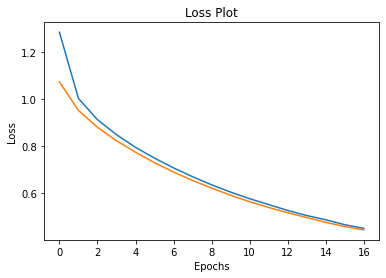

In [41]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [42]:
def evaluate(image):
    max_length = max_len
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [43]:
def beam_evaluate(image, beam_index = 35):
    max_length= max_len
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [44]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(20, 20))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [45]:
from nltk.translate.bleu_score import sentence_bleu

In [46]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 42.88819424803535
Real Caption: a young blond boy with long hair with a large innertube drapped around his body
Prediction Caption: a boy plays with a innertube drapped around his body


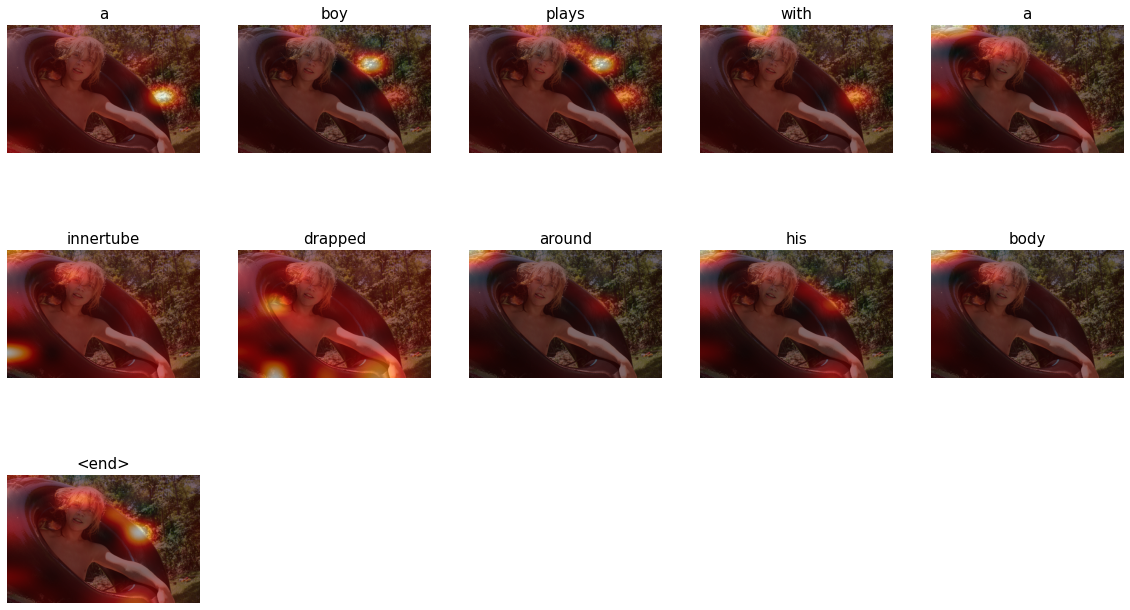

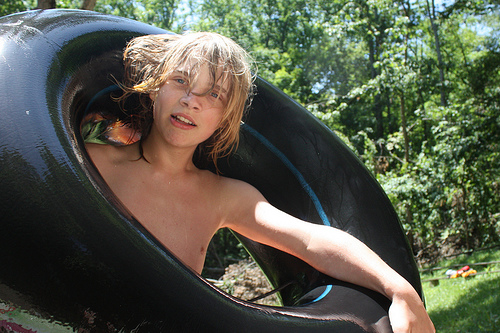

In [47]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [48]:
captions=beam_evaluate(test_image)
print(captions)

a blond with a tube
